In [1]:
import pandas as pd

In [2]:
fileloc = r'C:\Users\mvman\Downloads\acc_manualCoding.xlsx'
df = pd.read_excel(fileloc)

df.drop(columns = ['Unnamed: 0','Unnamed: 0.1'],inplace = True)

In [3]:
df.head(1)

,Events,EventCoding,Matched_word,Description,clean_text,Accuracy,parAccuracy,ManualCoder,"Accuracy(1 acc, 0 error)"
0,candlelight vigil,0,Candlelight vigil,A candlelight vigil or candlelit vigil is an o...,candlelight vigil candlelit vigil outdoor asse...,100,100,YL,1.0


In [4]:
text_to_add = ' conference day activism movement events annual symposium sexual aware awareness movements event protest'

In [5]:
for i in range(0,len(df)):
    if(df.loc[i,'EventCoding'] == 1):
        if(type(df.loc[i,'clean_text']) == str):
            df.loc[i,'clean_text'] += text_to_add

In [6]:
dfone = df[df.EventCoding == 1]
dfzero = df[df.EventCoding == 0]

dfone = dfone.reset_index()
dfone.drop(columns = ['index'],inplace = True)

all_text_one = ''
for i in range(0,len(dfone)):
    all_text_one += str(dfone.loc[i,'clean_text'])

In [7]:
dfone.shape,dfzero.shape

((378, 9), (317, 9))

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn import svm

In [9]:
x = df["clean_text"]
y = df['EventCoding']
#y = eventsdf["Accuracy(1 acc, 0 error)"]
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size = 0.2)

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(x_train.values.astype('U')) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(x_test.values.astype('U'))

### MB 

In [10]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
#fpr, tpr, thresholds = roc_curve(y_test, y_prob)
#roc_auc = auc(fpr, tpr)
#print('AUC:', roc_auc)

print("MB Accuracy Score -> ",accuracy_score(y_predict, y_test)*100)

              precision    recall  f1-score   support

           0       0.89      0.28      0.43        60
           1       0.64      0.97      0.77        79

    accuracy                           0.68       139
   macro avg       0.77      0.63      0.60       139
weighted avg       0.75      0.68      0.63       139

Confusion Matrix: [[17 43]
 [ 2 77]]
MB Accuracy Score ->  67.62589928057554


### SVM

In [11]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto')
SVM.fit(X_train_vectors_tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_vectors_tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  89.20863309352518


### KNN 

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
modelknn = KNeighborsClassifier(n_neighbors=3)
modelknn.fit(X_train_vectors_tfidf,y_train)
# predict the labels on validation dataset
predictions_KNN = modelknn.predict(X_test_vectors_tfidf)
# Use accuracy_score function to get the accuracy
print("KNN Accuracy Score -> ",accuracy_score(predictions_KNN, y_test)*100)

KNN Accuracy Score ->  66.18705035971223


### XGBoost

In [14]:
import xgboost as xgb

In [15]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train_vectors_tfidf,y_train)

xgb_cl.predict(X_test_vectors_tfidf)
print("XGB Accuracy Score -> ",accuracy_score(xgb_cl.predict(X_test_vectors_tfidf), y_test)*100)

XGB Accuracy Score ->  95.68345323741008


In [16]:
cm = confusion_matrix(y_test, predictions_SVM)

Text(69.0, 0.5, 'Truth')

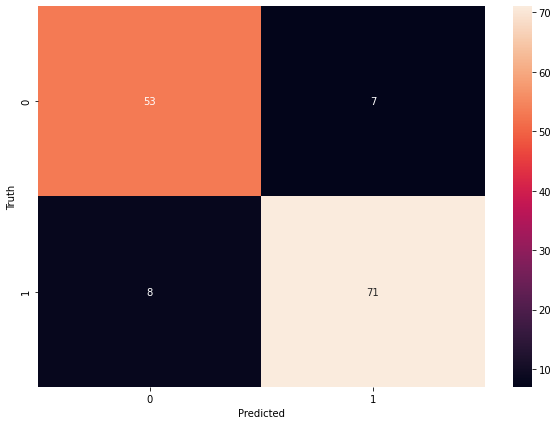

In [17]:
import seaborn as sn
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [18]:
#Text Preprocessing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [19]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [20]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [21]:
import wikipedia

In [22]:
#text = wikipedia.summary(wikipedia.search('Black Life Matter')[0])
text = wikipedia.summary('FIFA World Cup')
ct = finalpreprocess(text)
ct = [ct]
test_vector = tfidf_vectorizer.transform(ct)

SVM.predict(test_vector),nb_tfidf.predict(test_vector),xgb_cl.predict(test_vector)

(array([1], dtype=int64), array([1], dtype=int64), array([0]))

In [23]:
wikipedia.search('Fifa World Cup')

['FIFA World Cup',
 '2022 FIFA World Cup',
 '2018 FIFA World Cup',
 '2014 FIFA World Cup',
 '2010 FIFA World Cup',
 '2026 FIFA World Cup',
 '2006 FIFA World Cup',
 '2002 FIFA World Cup',
 '2030 FIFA World Cup',
 'List of FIFA World Cup finals']

In [24]:
wikipedia.summary('FIFA World Cup')

"The FIFA World Cup, often simply called the World Cup, is an international association football competition contested by the senior men's national teams of the members of the Fédération Internationale de Football Association (FIFA), the sport's global governing body. The championship has been awarded every four years since the inaugural tournament in 1930, except in 1942 and 1946 when it was not held because of the Second World War. The current champion is France, which won its second title at the 2018 tournament in Russia.\nThe current format involves a qualification phase, which takes place over the preceding three years, to determine which teams qualify for the tournament phase. In the tournament phase, 32 teams, including the automatically qualifying host nation(s), compete for the title at venues within the host nation(s) over about a month.\nAs of the 2018 FIFA World Cup, twenty-one final tournaments have been held and a total of 79 national teams have competed. The trophy has b

In [25]:
# ct

In [26]:
df.head(20)

,Events,EventCoding,Matched_word,Description,clean_text,Accuracy,parAccuracy,ManualCoder,"Accuracy(1 acc, 0 error)"
0,candlelight vigil,0,Candlelight vigil,A candlelight vigil or candlelit vigil is an o...,candlelight vigil candlelit vigil outdoor asse...,100,100,YL,1.0
1,der human rights day,1,Universal Declaration of Human Rights,The Universal Declaration of Human Rights (UDH...,universal declaration human right udhr interna...,56,72,YL,0.0
2,#16days of activism,1,PE 16 days of activism,16 Days of Activism Against Gender-Based Viole...,day activism gender base violence internationa...,88,95,YL,1.0
3,a policy dialogue,0,Centre for Policy Dialogue,"The Centre for Policy Dialogue (CPD), establis...",centre policy dialogue cpd establish rehman so...,74,94,YL,0.0
4,clear challenge 16,0,The Challenge: Total Madness,The Challenge: Total Madness is the thirty-fif...,challenge total madness thirty fifth season mt...,52,67,YL,0.0
5,11 documentary,0,The Documentary,The Documentary is the debut studio album by A...,documentary debut studio album american rapper...,83,86,YL,0.0
6,a parent-principal meeting,0,The Parent Trap (1998 film),The Parent Trap is a 1998 American romantic co...,parent trap american romantic comedy film dire...,42,43,YL,0.0
7,fest,0,Fest,A banquet (; French: [bɑ̃kɛ]) is a formal larg...,banquet french bɑkɛ formal large meal feast nu...,100,100,YL,0.0
8,the day of silence,1,Day of Silence,Day of Silence is GLSEN's annual day of action...,day silence glsen annual day action spread awa...,88,100,YL,1.0
9,symposium,0,Symposium,"In ancient Greece, the symposium (Greek: συμπό...",ancient greece symposium greek συμπόσιον sympo...,100,100,YL,1.0
